In [1]:
from jax import grad,jit,vmap,jacfwd,jacrev
import jax.numpy as jnp
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sklearn

In [2]:

def rbf_kernel_jax(X1, X2, gamma=1.0, sigma_f=1.0):
    sqdist = jnp.sum(X1**2, 1).reshape(-1, 1) + jnp.sum(X2**2, 1) - 2 * jnp.dot(X1, X2.T)
    return sigma_f**2 * jnp.exp(-gamma * sqdist)

def rbf_kernel_single(x1, x2, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    return sigma_f**2 * jnp.exp(-gamma * jnp.sum((x1 - x2)**2))


now I try to implement the derivatives of the kernel    
I want to do this for the helmholtz equation:  
\begin{align}   
 \mathcal{L}_x ^\omega = \frac{\partial^2}{\partial x^2} + \nu^2 
\end{align}     
The first step would be to use differential operator onto the kernel function twice. So that:
\begin{align}
K_{new}(x,x') = \mathcal{L}_x ^\nu \mathcal{L}_{x'} ^\nu K(x,x')
\end{align}   

\begin{align}   
    \mathcal{L}_x ^\nu \mathcal{L}_{x'} ^\nu k(x, x') = \left(\frac{\partial^2}{\partial x^2} + \nu^2\right)\left(\frac{\partial^2}{\partial x'^2} + \nu^2\right)k(x, x') 
\end{align} 
this then results in:
\begin{align*}
\mathcal{L}_x ^\nu \mathcal{L}_{x'}^\nu k(x, x') = & \frac{\partial^4}{\partial x^2 \partial x'^2} k(x, x') + \nu^2 \frac{\partial^2}{\partial x^2} k(x, x') + \nu^2 \frac{\partial^2}{\partial x'^2} k(x, x') + \nu^4 k(x, x')
\end{align*}
Because of the rbf, the two parts with the second derivative can be combined to:
\begin{align*}  
\mathcal{L}_x ^\nu \mathcal{L}_{x'}^\nu k(x, x') = & \frac{\partial^4}{\partial x^2 \partial x'^2} k(x, x') + 2\nu^2 \frac{\partial^2}{\partial x^2} k(x, x') + \nu^4 k(x, x')
\end{align*}
To make it more clear, I will call the first part of the result $A$ and the second part $B$, the third part does not need further calculations.

In the following I will try to implement this in code.  
For A we get:
\begin{align*}
A_{ij} = (16{\gamma}^4\cdot\left(x_i-y_j\right)^4-48{\gamma}^3\cdot\left(x_i-y_j\right)^2+12{\gamma}^2)\mathrm{e}^{-{\gamma}\cdot\left(x_i-y_j\right)^2}
\end{align*}
For B we get:
\begin{align*}
B_{ij} = (4{\gamma}^2\cdot\left(x_i-y_j\right)^2-2{\gamma})\mathrm{e}^{-{\gamma}\cdot\left(x_i-y_j\right)^2}
\end{align*}


A has to computed elementwise just like the kernel itself. I will now try to do this once with the expressions and once with autograd.I took some help/inspiration from https://jejjohnson.github.io/research_notebook/content/notes/kernels/kernel_derivatives.html

In [3]:
def A_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    
    kernel_values = rbf_kernel_jax(x, x_bar, gamma,sigma_f)
    #kernel_values = rbf_kernel_jax(x, x_bar, l= 1/np.sqrt(2*gamma), sigma_f_sq = sigma_f**2)

    n, m = x.shape[0], x_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist_sq = (x[i] - x_bar[j])**2
            factor = 16*gamma**4*dist_sq**2 - 48*gamma**3*dist_sq + 12*gamma**2
            dk_ff[i, j] = factor
    return dk_ff * kernel_values
def B_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    nu = hyperparameters[2]
    kernel_values = sigma_f**2*rbf_kernel_sklearn(x, x_bar, gamma)

    n, m = x.shape[0], x_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            dist_sq = np.sum(x[i] - x_bar[j])**2
            factor = 2*nu**2*(4*gamma**2 * dist_sq - 2*gamma)
            dk_ff[i, j] = factor*kernel_values[i,j]
    return dk_ff
def C_scratch(x,x_bar, hyperparameters):
    gamma, sigma_f = hyperparameters[0], hyperparameters[1]
    nu = hyperparameters[2]
    kernel_values = sigma_f**2*rbf_kernel_sklearn(x, x_bar, gamma)

    return nu**4*kernel_values

In [4]:

gamma = 1
@jit
def rbf_kernel_single(x1, x2, params):
    x1, x2 = x1.flatten(), x2.flatten()
    gamma, sigma_f = params[0], params[1]
    return jnp.squeeze(sigma_f**2 * jnp.exp(-gamma * jnp.sum((x1 - x2)**2)))


@jit
def A_autograd(x,x_bar, hyperparameters):
    """only works for 1D arrays atm """
    x, x_bar = x.flatten(), x_bar.flatten()
    # Vectorize the kernel function, in_axes specifies which argument is vectorized. I could also use the lambda function for the hyperparameter argument, but this is more readable.
    params_rbf = hyperparameters[:2]
    

    # Now compute the derivatives
    second_derivative_x = grad(grad(rbf_kernel_single, argnums=1), argnums=1)
    fourth_derivative = grad(grad(second_derivative_x, argnums=0), argnums=0)

    # Vectorize the derivative function 
    fourth_derivative_vectorized = vmap(vmap(fourth_derivative, in_axes=(None, 0, None)), in_axes=(0, None, None))

    
    K_4th_derivative = fourth_derivative_vectorized(x, x_bar, params_rbf)
    return K_4th_derivative 



In [5]:
x = np.linspace(0, 1, 100)
x_bar = np.linspace(0, 1, 100)
hyperparameters = [1,1,1]
#print(A_autograd(x,x_bar,hyperparameters))
x_1 = np.linspace(0, 1, 100).reshape(-1,1)
x_bar_1 = np.linspace(0, 1, 100).reshape(-1,1)
hyperparameters = [1,1,1]
#print(A_scratch(x_1,x_bar_1,hyperparameters))
print(np.allclose(A_autograd(x,x_bar,hyperparameters),A_scratch(x_1,x_bar_1,hyperparameters)))
print((A_autograd(x,x_bar,hyperparameters)-A_scratch(x_1,x_bar_1,hyperparameters)).sum())
#%timeit A_autograd(x,x_bar,hyperparameters)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


False
0.00027780235


There somehow is a difference now. Before there was none. However, the difference is quite small, so this could be because of some numerical error.


In [6]:
@jit
def B_autograd(x,x_bar, hyperparameters):
    x, x_bar = x.flatten(), x_bar.flatten()
    params_rbf = hyperparameters[:2]
    nu = hyperparameters[2]
    first_vmap = vmap(rbf_kernel_single, in_axes=(None, 0, None))
    vectorized_rbf_kernel = vmap(first_vmap, in_axes=(0, None, None))

    # here we only need the second derivative once with respect to x2
    second_derivative_x2 = grad(grad(rbf_kernel_single, argnums=1), argnums=1)
    second_derivative_x2_vectorized = vmap(vmap(second_derivative_x2, in_axes=(None, 0, None)), in_axes=(0, None, None))
    
    return 2*nu**2*second_derivative_x2_vectorized(x, x_bar, params_rbf)
@jit
def C_vectorized(x,x_bar,hyperparameters):
    x, x_bar = x.flatten(), x_bar.flatten()
    params_rbf = hyperparameters[:2]
    nu = hyperparameters[2]
    first_vmap = vmap(rbf_kernel_single, in_axes=(None, 0, None))
    vectorized_rbf_kernel = vmap(first_vmap, in_axes=(0, None, None))
    return nu**4*vectorized_rbf_kernel(x, x_bar, params_rbf)
#compare with the scratch function
hyperparameters = [1,3,4]
x = np.linspace(0, 10, 100).reshape(-1,1)
y = np.linspace(0, 10, 100).reshape(-1,1)
x_1 = np.linspace(0, 10, 100)
y_1 = np.linspace(0, 10, 100)
print("B - comparison")
# print(B_autograd(x_1,y_1,hyperparameters))
# print(B_scratch(x,y,hyperparameters))
print(np.allclose(B_autograd(x_1,y_1,hyperparameters),B_scratch(x,y,hyperparameters)), "B","\n")
print((B_autograd(x_1,y_1,hyperparameters)-B_scratch(x,y,hyperparameters)).sum(),"B","\n")
print("C - comparison")
# print(C_vectorized(x_1,y_1,hyperparameters))
# print(C_scratch(x,y,hyperparameters))
print(np.allclose(C_vectorized(x_1,y_1,hyperparameters),C_scratch(x,y,hyperparameters)),"C")
    

B - comparison
False B 

-0.008566953 B 

C - comparison
True C


Again the same result. So the implementation shold be correct. In the scratch version I used +nu**2 and instead of -nu**2. I could change this but I think it is clear that the autograd implementation is correct.    
Now lets try to implement the kernel with the derivatives.  
At first I want to compute the marginal log likelihood to optimize the hyperparameters $\gamma, \sigma_f$ and the infered hyperparameter from the Helmholtzequation $\nu$.      
The marginal log likelihood is given by:
\begin{align*}
\log p(\mathbf{y} \mid \mathbf{X}, \gamma, \sigma_f, \nu) = & -\frac{1}{2}\mathbf{y}^T\left(K_{new} + \sigma_n^2\mathbf{I}\right)^{-1}\mathbf{y} - \frac{1}{2}\log\left|K_{new} + \sigma_n^2\mathbf{I}\right| - \frac{n}{2}\log 2\pi
\end{align*}

In [7]:
def create_derivative_matrix_scratch(X, X_bar,noise, hyperparameters):
    """ create the derivative matrix with the three functions above """
    A = A_scratch(X, X_bar, hyperparameters)
    B = B_scratch(X, X_bar, hyperparameters)
    C = C_scratch(X, X_bar, hyperparameters)
    return A + B + C 
@jit
def create_derivative_matrix_jax(X, X_bar,noise, hyperparameters):
    """ create the derivative matrix with the three functions above """
    A = A_autograd(X, X_bar, hyperparameters)
    B = B_autograd(X, X_bar, hyperparameters)
    C = C_vectorized(X, X_bar, hyperparameters)
    
    return (A + B + C) 

In [8]:
noise = 0.001
size = 100
x_1, y_1 = np.linspace(0,1,size), np.linspace(0,2,size)
hyperparameters = [1,3,4]
x,y = np.linspace(0,1,size).reshape(-1,1), np.linspace(0,2,size).reshape(-1,1)
np.allclose(create_derivative_matrix_jax(x_1,y_1,noise,hyperparameters), create_derivative_matrix_scratch(x,y,0.001, hyperparameters))
%timeit create_derivative_matrix_jax(x_1,y_1,noise,hyperparameters)
%timeit create_derivative_matrix_scratch(x,y,noise,hyperparameters)

26.6 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
122 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Even for smaller datasets the jax implementation is much faster. With increasing size of the dataset the autograd approach is extremely more efficient. It is worth to note that jax is not jet running on the gpu. So the speedup could be even higher.(When using @jit for the jax implementation it gets even faster.)   

Now the next step is to create a dataset and to optimize the hyperparameters. I will just sample some points from the general solution of the one dimensional Helmholtz equation. The general solution is given by:
\begin{align*}
u(x) = A\cdot\mathrm{e}^{i\cdot\nu\cdot x} + B\cdot\mathrm{e}^{-i\cdot\nu\cdot x}
\end{align*}
With simple boundary conditions we get:
\begin{align*}
u(x) = A \cdot sin(\nu x + \phi)
\end{align*}
Generally the solution would be an infinite sum of all the different possible wavenumbers. (String fixed between two walls).
I just only use one case n for creating the data.

1.2566370614359172 k


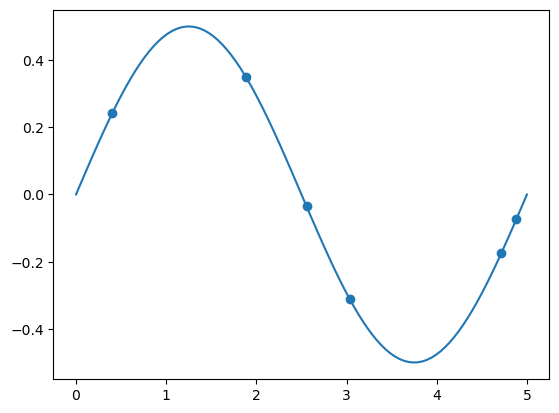

In [21]:
import matplotlib.pyplot as plt

L = 5.0  # Length of the domain
N = 100  # Number of grid points
n = 2  # Mode parameter
A = 0.5
# Compute the wave number
k = n * np.pi / L
print(k, "k")
n_samples = 6
noise = 0.0001

def analytical_solution(x,k):
    return A*np.sin(k*x)
rng = np.random.default_rng(seed = 4)
x_train = rng.uniform(0,L,n_samples)
x_train = np.sort(x_train)
targets_train = analytical_solution(x_train,k) + noise*np.random.randn(x_train.size)
x_test = np.linspace(0,L,100)
plt.scatter(x_train, targets_train)
plt.plot(x_test, analytical_solution(x_test, k))

Ok now we have some data. Lets first compute the marginal log likelihood as defined before and then optimize it with respect to the parameters. For some reason the optimization does not work when I compute the K matrix with the jax implementation.

In [22]:
from scipy.optimize import minimize
from tqdm import tqdm

def log_marginal_likelihood(Kernel:callable, x,targets,data_noise,hyperparams):
    #gamma, sigma_f, nu = hyperparams[0],hyperparams[1],hyperparams[2
    K = create_derivative_matrix_jax(x,x,data_noise,hyperparams) + data_noise * jnp.eye(len(x)) #+ 1e-6*jnp.eye(len(x)) #some extra jitter
    
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
    mll = 1/2 * jnp.dot(targets.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(x)/2 * jnp.log(2*jnp.pi)
    return mll

hyperparameters = [1,1,1]
print(log_marginal_likelihood(create_derivative_matrix_jax,x_train,targets_train,noise,hyperparams=hyperparameters))

def log_marginal_likelihood_to_optimize(Kernel:callable, x,targets,data_noise):
    def function_to_optimize(hyperparams):
        mll = log_marginal_likelihood(Kernel, x,targets,data_noise,hyperparams)
        return mll
    return function_to_optimize

def optimization_restarts(Kernel: callable,n_restarts, X, X_bar, targets, noise):
    
    best_mll = np.inf
    best_theta = np.zeros((3))
    for i in tqdm(range(n_restarts)):
        rng = np.random.default_rng()
        theta_initial = rng.uniform(0,2,3)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X, targets, noise), x0=theta_initial,
                    method='L-BFGS-B', bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res
    return best_theta

res = optimization_restarts(create_derivative_matrix_jax,1000,x_train,x_train,targets_train,noise)
print(res.x)
print(log_marginal_likelihood(create_derivative_matrix_jax,x_train,targets_train,noise,hyperparams=res.x))

8.336312


100%|██████████| 1000/1000 [00:15<00:00, 63.83it/s]

[0.10962255 1.14126705 0.17949509]
1.2514653


There is still something wrong in the optimization process, because the value of the mll is higher after optimization enven while minimizing the function. Ok now i want to make predictions with the optimized hyperparameters. I will achive this by using the conditional distribution of the gaussian process. The conditional distribution is given by:
\begin{align*}
p(\mathbf{f_*} \mid \mathbf{X_*}, \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{f_*} \mid \mathbf{K_{**}}\mathbf{K_{xx}}^{-1}\mathbf{y}, \mathbf{K_{**}} - \mathbf{K_{**}}\mathbf{K_{xx}}^{-1}\mathbf{K_{xx}}\mathbf{K_{**}})
\end{align*}

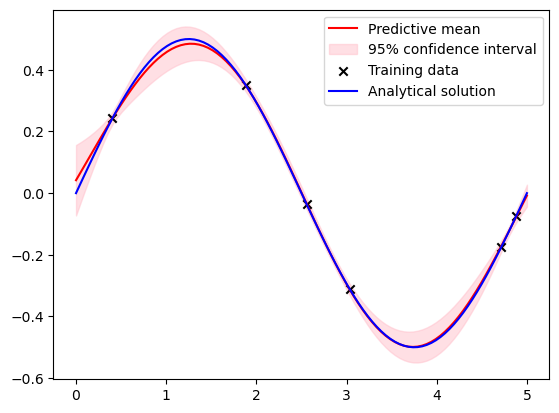

In [23]:
from gaussian_processes_util import plot_gp

def posterior_distribution(Kernel:callable, X, X_bar,noise_data, hyperparams):
    K = create_derivative_matrix_jax(X, X,noise_data,hyperparams) + noise_data * jnp.eye(len(X))
    K_s = create_derivative_matrix_jax(X, X_bar,noise_data,hyperparams)
    K_ss = create_derivative_matrix_jax(X_bar, X_bar,noise_data,hyperparams)
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets_train))
    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    return f_star, var_f_star
hyperparameters = res.x
f_star, var_f_star = posterior_distribution(create_derivative_matrix_jax,x_train,x_test,noise,hyperparams = hyperparameters)
var_plot = jnp.diag(var_f_star)
plt.plot(x_test, f_star, 'r-', label='Predictive mean')

plt.fill_between(x_test, f_star - 2 * jnp.sqrt(var_plot), f_star + 2 * jnp.sqrt(var_plot), color='pink',alpha = 0.5, label='95% confidence interval')
plt.scatter(x_train, targets_train, label='Training data', color='black', marker='x')
plt.plot(x_test, analytical_solution(x_test, k), 'b-', label='Analytical solution')
plt.legend()

The predictions are not very good tbh. When comparing the predictions with just the basic prediction using a vanilla RBF kernel the vanilla is much better. So something must be wrong(hopefully). Probably in the optimization process. Even if I use ridicioulus values for $nu$ the predictions stay the same. So somehow nu doesnt do anything really...

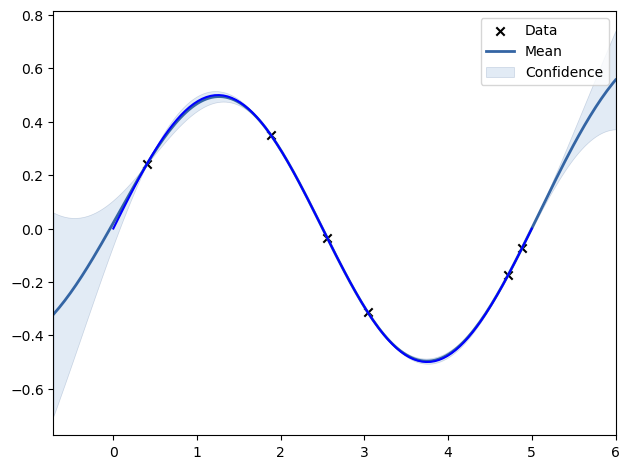

In [24]:
import GPy
kernel  = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1)
m = GPy.models.GPRegression(x_train.reshape(-1,1), targets_train.reshape(-1,1), kernel)
m.optimize()
m.plot()
plt.plot(x_test, analytical_solution(x_test, k), 'b-', label='Analytical solution')


I want to fix the issiu with the grad function. The problem is it only takes scalar values. So when I use grad tice i run into an error for the second grad. For the kernel it already works.

In [25]:
import GPy

class CustomKernel(GPy.kern.Kern):
    def __init__(self, input_dim, variance=1.,lengthscale=1.,ode_param=1., active_dims=None):
        super(CustomKernel, self).__init__(input_dim, active_dims, 'custom_kernel')
        
        assert input_dim == 1, "For this kernel we assume input_dim=1"
        
        self.variance = GPy.Param('variance', variance)
        self.lengthscale = GPy.Param('lengthscale', lengthscale)
        
        self.ode_param = GPy.Param('ode_param', ode_param)
        self.link_parameters(self.variance, self.lengthscale, self.ode_param)

    def K(self, X, X2):
        if X2 is None: X2 = X
        """ create the derivative matrix with the three functions above """
        
        hyperparameters = jnp.array([self.variance, self.lengthscale, self.ode_param])
        A = A_autograd(X, X2, hyperparameters)
        B = B_autograd(X, X2, hyperparameters)
        C = C_vectorized(X, X2, hyperparameters)
        
        return np.array(A + B + C)
    def K_single(self,X, X2, params):
        if X2 is None: X2 = X
        
        X, X2 = jnp.squeeze(X), jnp.squeeze(X2)
        params_rbf = jnp.array(params[:2])
        nu = jnp.array(params[2])

        # A part
        second_derivative_x = grad(grad(rbf_kernel_single, argnums=1), argnums=1)
        fourth_derivative = grad(grad(second_derivative_x, argnums=0), argnums=0)(X,X2,params_rbf)

        #B part
        second_derivative_x2 = grad(grad(rbf_kernel_single, argnums=1), argnums=1)(X,X2,params_rbf)
    
        #C part
        no_dev = rbf_kernel_single(X, X2, params_rbf) 
        return (fourth_derivative + second_derivative_x2* 2*nu**2 + no_dev * nu**4)
        

    def Kdiag(self, X):
        return self.variance * np.ones(X.shape[0])

    def  update_gradients_full(self,DL_dK,X, X2):
        
        if X2 is None: X2 = X
        
        """ create the derivative matrix with the three functions above """
        hyperparameters = [self.lengthscale,self.lengthscale, self.ode_param]
        hyperparameters = jnp.array(hyperparameters)
        #calculates the jacobian of the kernel matrix with respect to the hyperparameters
        jac = jacfwd(self.K_single,argnums=2)
        #create a wrapper (there was a rpblem with the outputshape of the jacobian with this we get out desired (n,n,3) shape)
        def jac_wrapper(x, x2, params):
            j = jac(x, x2, params)
            return j.reshape(-1)

        #vectorize the jacobian
        vectorized_jac = vmap(vmap(jac_wrapper, in_axes=(None, 0, None)), in_axes=(0, None, None))
        jacobian = vectorized_jac(X, X2, hyperparameters)
        dk_dgamma = jacobian[:,:,0]
        dk_dsigma = jacobian[:,:,1]
        dk_dnu = jacobian[:,:,2]
        
        self.variance.gradient = np.sum(DL_dK*dk_dsigma)
        self.lengthscale.gradient = np.sum(DL_dK*dk_dgamma)
        self.ode_param.gradient = np.sum(DL_dK*dk_dnu)

    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance.gradient = np.sum(dL_dKdiag)
        self.lengthscale.gradient = 0  # no lengthscale term in the diagonal

    def gradients_X(self, dL_dK, X, X2):
        # I won't derive this here, but this gives the derivative of the kernel wrt X
        pass

    def gradients_X_diag(self, dL_dKdiag, X):
        # Similarly, the derivative of the diagonal of a kernel matrix wrt X
        pass
    

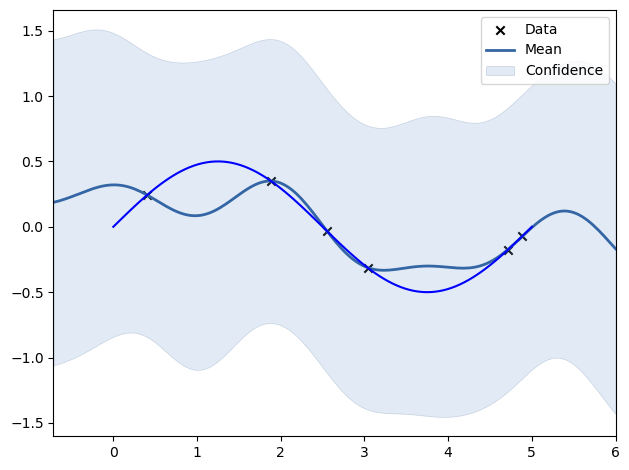

In [26]:
kernel = CustomKernel(input_dim=1, variance=1., lengthscale=1., ode_param=1.)
x_train = x_train.reshape(-1,1)
y_train = targets_train.reshape(-1,1)
m = GPy.models.GPRegression(x_train, y_train, kernel)
m.Gaussian_noise.variance.fix(noise)
#m.optimize_restarts(num_restarts = 2,messages=True)
m.optimize(ipython_notebook=True,messages=True)
#set the ode param to the true value

m.plot()
plt.plot(x_test, analytical_solution(x_test, k), 'b-', label='Analytical solution')


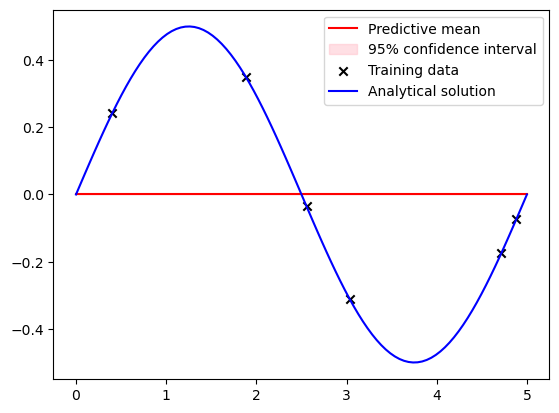

In [28]:
def helmholtz_kernel(x,y,hyperparameters):
    sigma_f,k_0 = hyperparameters[0], hyperparameters[1]
    return sigma_f**2 *jnp.cos(k_0*(x-y))
def log_marginal_likelihood(Kernel:callable, x,targets,data_noise,hyperparams):
    #gamma, sigma_f, nu = hyperparams[0],hyperparams[1],hyperparams[2
    K = Kernel(x,x,hyperparams) + data_noise * jnp.eye(len(x)) #+ 1e-6*jnp.eye(len(x)) #some extra jitter
    
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))
    mll = 1/2 * jnp.dot(targets.T,alpha) +0.5*jnp.sum(jnp.log(jnp.diagonal(L))) + len(x)/2 * jnp.log(2*jnp.pi)
    return mll
def log_marginal_likelihood_to_optimize(Kernel:callable, x,targets,data_noise):
    def function_to_optimize(hyperparams):
        mll = log_marginal_likelihood(Kernel, x,targets,data_noise,hyperparams)
        return mll
    return function_to_optimize
def optimization_restarts(Kernel: callable,n_restarts, X, X_bar, targets, noise):
    
    best_mll = np.inf
    best_theta = np.zeros((2))
    for i in tqdm(range(n_restarts)):
        rng = np.random.default_rng()
        theta_initial = rng.uniform(0,1,2)
        res = minimize(log_marginal_likelihood_to_optimize(Kernel, X, targets, noise), x0=theta_initial,
                    method='L-BFGS-B', bounds=((1e-5, 1), (1e-5, None)))
        if res.fun < best_mll:
            best_mll = res.fun
            best_theta = res
    return best_theta
res = optimization_restarts(helmholtz_kernel,1000,x_train,x_train,targets_train,noise)
print(res)

def posterior_distribution(Kernel:callable, X, X_bar,noise_data, hyperparams):
    K = Kernel(X, X,hyperparams) + noise_data * jnp.eye(len(X))
    K_s = Kernel(X, X_bar,hyperparams)
    K_ss = Kernel(X_bar, X_bar,hyperparams)
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets_train))
    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    return f_star, var_f_star
hyperparameters = res.x
f_star, var_f_star = posterior_distribution(helmholtz_kernel,x_train,x_test,noise,hyperparams = hyperparameters)
var_plot = jnp.diag(var_f_star)
plt.plot(x_test, f_star, 'r-', label='Predictive mean')

plt.fill_between(x_test, f_star - 2 * jnp.sqrt(var_plot), f_star + 2 * jnp.sqrt(var_plot), color='pink',alpha = 0.5, label='95% confidence interval')
plt.scatter(x_train, targets_train, label='Training data', color='black', marker='x')
plt.plot(x_test, analytical_solution(x_test, k), 'b-', label='Analytical solution')
plt.legend()